In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('/home/xilinx/jupyter_notebooks/qickdawg/src/')

import qickdawg as qd
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
qd.start_client("172.16.26.5")

In [90]:
default_config = qd.NVConfiguration()

default_config.test = True
default_config.mw_readout_channel = 1
default_config.ddr4 = True
default_config.ddr4_channel = 0
default_config.n_ddr4_chunks = 60000

default_config.adc_channel = 0 

default_config.mw_channel = 1
default_config.mw_nqz = 1
default_config.mw_gain = 5000

default_config.laser_gate_pmod = 0

default_config.relax_delay_treg = 100 # between each rep, wait for everything to catch up, mostly aom


In [91]:
config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
prog = qd.LaserOn(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
on_value  = np.mean(data)
print('Approximate on intensity {} ADC units'.format(on_value))

prog = qd.LaserOff(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
off_value  = np.mean(data)
print('Approximate off intensity {} ADC units'.format(off_value))


Approximate on intensity 1954.263725490196 ADC units
Approximate off intensity -9.868627450980393 ADC units


In [92]:
for i in range(2):
    
    qd.soc.clear_ddr4()

    config = copy(default_config)
    
    config.mw_gain = 30000
    config.mw_fMHz = 2870
    config.mw_pi2_treg = 100
    
    config.pre_init = True

    config.relax_delay_treg = 0

    config.laser_on_treg = 5000 # in us
    config.readout_integration_treg = 700  # us
    config.readout_reference_start_treg = 3500 # us

    config.laser_readout_offset_treg = 135 #
    config.mw_readout_delay_treg = 45

    config.add_exponential_sweep('delay', 'tus', start=0.05, stop=10000, scaling_factor='3/2')

    config.reps = 1

    config.ddr4_channel = i

    prog = qd.T1DelaySweep(config)
    d = prog.acquire(progress=True)

    if i == 0:
        laser_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)[:, 0]
    elif i == 1:
        mw_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)
        mw_real = mw_ddr4[:, 0]
        mw_imag = mw_ddr4[:, 1]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [93]:
start = 5370
end = 5460

phase = np.arctan(np.mean(mw_real[start:end]) / np.mean(mw_imag[start:end]))
phase -= np.pi/2

x = mw_real * np.cos(phase) - mw_imag * np.sin(phase)
y = mw_real * np.sin(phase) + mw_imag * np.cos(phase)

# plt.plot(laser_ddr4, label='Laser')
# plt.plot(x, label='Microwave I')
# plt.plot(y, label='Microwave Q')
# plt.legend()

In [94]:
laser_start_treg = find_peaks(np.gradient(laser_ddr4), height=200)[0]
laser_end_treg = find_peaks(np.gradient(-laser_ddr4), height=200)[0]
mw_start_treg = find_peaks(np.gradient(np.abs(x)), height=150)[0]
mw_end_treg = find_peaks(np.gradient(-np.abs(x)), height=150)[0]

laser_norm = laser_ddr4 /np.max(laser_ddr4)
x_norm = x /np.max(x)

In [95]:
# for i in range(len(mw_start_treg)):
#     i_end = mw_start_treg[i] + (config.mw_pi2_treg * 2 + d.sweep_treg[i] + config.laser_on_treg) * 2 + 10
    
#     plt.plot(x_norm[mw_start_treg[i] - 10: i_end]  + i * 1.5)
#     plt.plot(laser_norm[mw_start_treg[i]- 10: i_end] + i * 1.5)


10520


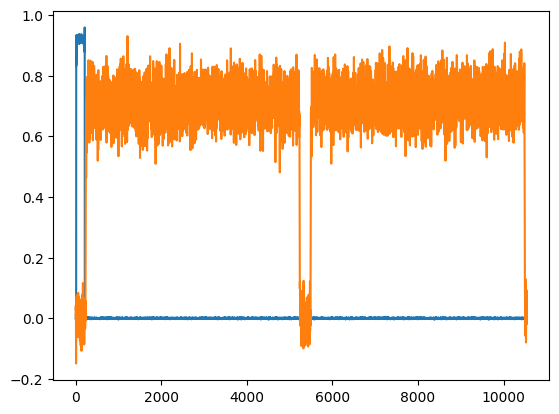

In [96]:
# should be equal to the mw pulse time in treg for pi/2, pi, pi/2

i = 0
i_end = mw_start_treg[i] + (config.mw_pi2_treg * 2 + d.sweep_treg[i] + config.laser_on_treg + config.mw_readout_delay_treg) * 2 + 10

plt.plot(x_norm[mw_start_treg[i] - 10: i_end]  + i * 1.5)
plt.plot(laser_norm[mw_start_treg[i]- 10: i_end] + i * 1.5)
print(i_end - mw_start_treg[i] - 10)

3656940


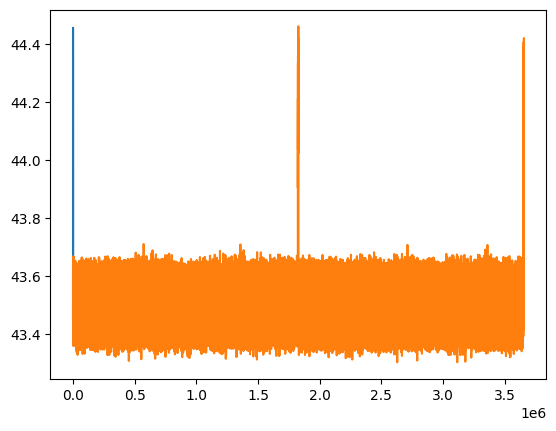

In [101]:
i = len(mw_start_treg) - 2
i_end = mw_start_treg[i] + (config.mw_pi2_treg * 2 + d.sweep_treg[i] + config.laser_on_treg + config.mw_readout_delay_treg) * 2

plt.plot(x_norm[mw_start_treg[i] - 10: i_end]  + i * 1.5)
plt.plot(laser_norm[mw_start_treg[i]- 10: i_end] + i * 1.5)
print(i_end - mw_start_treg[i] - 10)

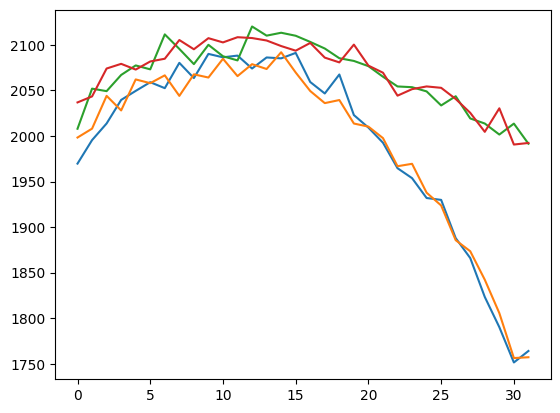

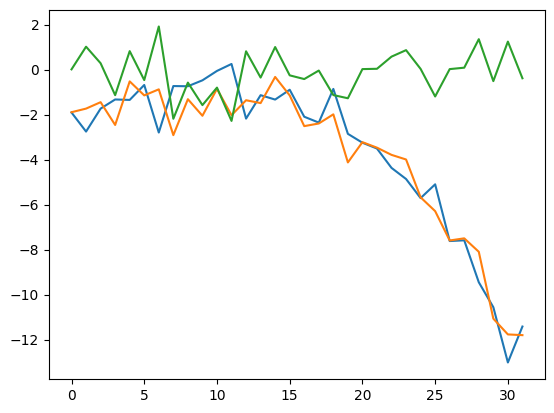

In [102]:
plt.plot(d.signal1 / config.readout_integration_treg)
plt.plot(d.signal2 / config.readout_integration_treg)
plt.plot(d.reference1 / config.readout_integration_treg)
plt.plot(d.reference2 / config.readout_integration_treg)
plt.show()

plt.plot(d.contrast1)
plt.plot(d.contrast2)
plt.plot(d.contrast)

In [103]:
print(prog.asm())


// Program

            regwi 1, $22, 626961066;            //freq = 2507844267
            bitwi 1, $22, $22 << 2;
            mathi 1, $22, $22 + 3;
            regwi 1, $25, 30000;                //gain = 30000
            regwi 1, $23, 0;                    //phase = 0
            regwi 1, $26, 589924;               //phrst| stdysel | mode | | outsel = 0b01001 | length = 100 
            regwi 1, $1, 15;                    //'delay' <= 15 
            synci 100;
            regwi 0, $16, 8192;                 //out = 0b0010000000000000
            seti 7, 0, $16, 0;                  //ch =0 out = $16 @t = 0
            seti 7, 0, $0, 10;                  //ch =0 out = 0 @t = 0
            synci 100;
            regwi 0, $16, 1;                    //out = 0b0000000000000001
            seti 7, 0, $16, 0;                  //ch =0 out = $16 @t = 0
            seti 7, 0, $0, 5000;                //ch =0 out = 0 @t = 0
            synci 5000;
            regwi 0, $13, 0;
            re